In [1]:
from langgraph.graph import StateGraph,START,END
from pydantic import BaseModel,Field
from typing import TypedDict,List,Optional,Annotated
from utils.schema import State

In [2]:
#agent imports
from agents.universal_naming_agent import universal_name_refiner_v4
from agents.universal_parser_agent import parser_graph
from agents.comparison_agent import get_comparison_agent
    

d:\smart_search_fino\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\smart_search_fino\.venv\lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
from agents.db_hooks import check_doc_with_name_version,check_doc_present, archive_chunk, upsert_chunks, upsert_doc,query_doc_exists

In [4]:
def routing_to_parsing(state:State):
    revision_tag = state['revision_tag']
    if revision_tag is None:
        filename = state['base_doc_name']
        version_no = state['version']
        is_present = check_doc_with_name_version(filename,version_no)
        
        if is_present:
            return "end"
        else:
            return "parsing_agent"
    return "parsing_agent"
    

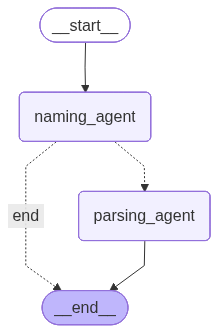

In [5]:
builder = StateGraph(State)

builder.add_node("naming_agent",universal_name_refiner_v4)
builder.add_node("parsing_agent",parser_graph)

builder.add_edge(START,"naming_agent")

builder.add_conditional_edges(
    "naming_agent",
    routing_to_parsing,
    {
        "parsing_agent":"parsing_agent",
        "end":END
    }
)

builder.add_edge("parsing_agent",END)

graph = builder.compile()

graph


In [6]:
def routing_after_parsing(state:State):
    revision_tag = state['revision_tag']
    filename = state['base_doc_name']
    version_no = state['version']
    content_hash = state.get('content_hash') # Ensure hash is in your state

    # 1. NEW: Check if this exact content is already in the system
    if content_hash and query_doc_exists(content_hash):
        print(f"Duplicate content detected for {filename}. Skipping to END.")
        return "end" # Or whatever your 'Finish' node is named
    if revision_tag is not None:
        return "compare"
    
    if check_doc_present(filename, version_no):
        return "archive_existing_chunks"
     
    return "push_all"


In [7]:
def remove_chunks(state:State):
    doc_id = state['base_doc_name']
    
    try:
        archive_chunk(doc_id)
    except Exception as e:
        print(f"Error Executing archieve Chunk: {e}")
    
    return state

In [8]:
def push_chunks(state:State):
    
    chunks = state['chunks']
    
    try:
        upsert_doc(state['base_doc_name'],state['version'],state['extraction_stats'],state['content_hash'])
        upsert_chunks(chunks)
    except Exception as e:
        print(f"Error Executing doc or chunk upsert: {e}")
    
    return state

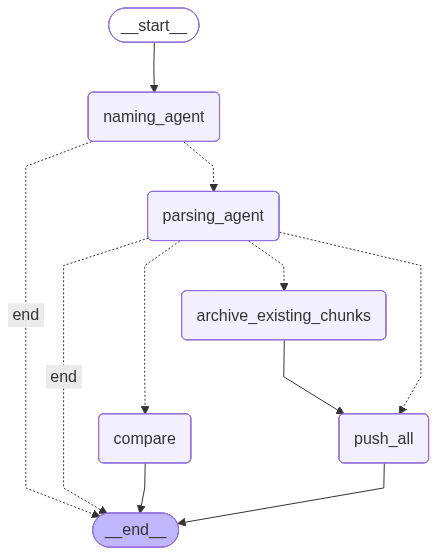

In [9]:
builder = StateGraph(State)

builder.add_node("naming_agent",universal_name_refiner_v4)
builder.add_node("parsing_agent",parser_graph)
builder.add_node("archive_existing_chunks",remove_chunks)
builder.add_node("push_all",push_chunks)
builder.add_node("compare",get_comparison_agent)

builder.add_edge(START,"naming_agent")

builder.add_conditional_edges(
    "naming_agent",
    routing_to_parsing,
    {
        "parsing_agent":"parsing_agent",
        "end":END
    }
)
builder.add_conditional_edges(
    "parsing_agent",
    routing_after_parsing,
    {
        "archive_existing_chunks":"archive_existing_chunks",
        "push_all":"push_all",
        "compare":"compare",
        "end":END
    }
)

builder.add_edge("archive_existing_chunks","push_all")
builder.add_edge("compare",END)
builder.add_edge("push_all",END)

graph = builder.compile()
graph

In [10]:
from agents.universal_parser_agent import init_worker
init_worker()

Embedding model initialized. 64 batch size, CPU device.


In [12]:
final = graph.invoke({"original_filename":r"Website_Backup\annual_return_mgt_7_4_v1.pdf"})
final

Consider using the pymupdf_layout package for a greatly improved page layout analysis.
Document annual_return_mgt_7_4 registered successfully.
Successfully upserted 62 chunks for annual_return_mgt_7_4


{'original_filename': 'Website_Backup\\annual_return_mgt_7_4_v1.pdf',
 'normalized_filename': 'annual_return_mgt_7_4_v1.pdf',
 'version': 'v1',
 'revision_tag': None,
 'is_collision': False,
 'confidence': 1.0,
 'version_detected': True,
 'base_doc_name': 'annual_return_mgt_7_4',
 'content_hash': 'f9e00599e93ca7a88e199b0d17d97959e6332213d8c65ad7ed24939d49e29b24',
 'raw_text': "Page 1 of 16\n\nFORM NO. MGT-7 \n[Pursuant to sub-Section(1) of section 92 of \nthe Companies Act, 2013 and sub-rule (1) of \nrule 11of the Companies (Management and \nAdministration) Rules, 2014] Annual Return \n(other than OPCs and Small \nCompanies) \n\nI. REGISTRATION AND OTHER DETAILS\n\n(i) * Corporate Identification Number (CIN) of the company\nL65100MH2007PLC171959\n\nHindi\nEnglish\nForm language\n\nRefer the instruction kit for filing the form.\n\nGlobal Location Number (GLN) of the company\n\n(ii) (a) Name of the company\n(b) Registered office address\n\nMindspace Juinagar, 8th Floor, Plot No. Gen 2/1/

In [12]:
final['report']

{'total_new': 17,
 'unchanged': 0,
 'new_added': 17,
 'old_archived': 15,
 'exact_unchanged': 0,
 'fuzzy_unchanged': 0,
 'total_old': 15,
 'matched_old': 0,
 'to_archive': 15,
 'storage_savings': '0.0%',
 'action': 'sync_complete'}